# Plotting satellite data with datashader

This example demonstrates plotting with datashader data that has been loaded from Iris cubes.

## Introduction

Datashader... "is a graphics pipeline system for creating meaningful representations of large amounts of data."

Here we'll show the outcomes of two of three different experiments:
 * loading and plotting a small dataset from an Iris cube,
 * loading and plotting a large-ish dataset from an Iris cubelist
 * (loading and plotting a month's worth of `SSMIS` data retrieved from MetDB and pickled.)
 
### Setup

In [21]:
%matplotlib notebook

import datashader as ds
import iris
import matplotlib.pyplot as plt
import pandas as pd

from datashader_utils.mpl_wrapper import LiveImageDisplay

### Plotting function

This generalised function takes a pandas dataframe and plots the dataframe using datashader. The plot is shown using matplotlib as rather than bokeh.

In [13]:
def plot(dataframe, col1, col2,
         reduction=None, col_reduction=None):
    # Variables.
    xmin = -180.0
    ymin = -90.0
    xmax = 180.0
    ymax = 90.0

    # See https://gist.github.com/mdboom/048aa35df685fe694330764894f0e40a.
    img = LiveImageDisplay(dataframe, col1, col2, 500, 500,
                           agg_reduction=reduction,
                           agg_reduction_col=col_reduction)
    z = img(xmin, xmax, ymin, ymax)

    # Set up a tweaked colormap.
    vir_cm = plt.cm.viridis
    vir_cm.set_under('w')
    vir_cm.set_bad('w')

    fig1, ax2 = plt.subplots(1, 1)
    m = ax2.imshow(z, origin='lower', extent=(xmin, xmax, ymin, ymax),
                   cmap=vir_cm, vmin=0.1)
    plt.colorbar(m)

    # Connect for changing the view limits
    ax2.callbacks.connect('xlim_changed', img.ax_update)
    ax2.callbacks.connect('ylim_changed', img.ax_update)

    plt.show()

### DataFrame construction functions

These take data from a variety of sources and construct pandas DataFrames from the data.

The sources are:
 * Iris cube,
 * Iris cubelist, and
 * (MetDB data.)

In [5]:
import os

def obscubes_to_pandas_df(fp, fn, name):
    cubes = iris.load(os.path.join(fp, fn))
    channel = 38
    df = pd.DataFrame({'data': cubes.extract(name)[0].data[channel],
                       'latitude': cubes.extract('latitude')[0].data,
                       'longitude': cubes.extract('longitude')[0].data,
                       'time': cubes.extract('time')[0].data,
                       'satid': cubes.extract('SatId')[0].data,
                       })
    df['cat_satid'] = df['satid'].astype('category')
    return df

def cube_to_pandas_df(fp, fn, name):
    cube = iris.load_cube(os.path.join(fp, fn), name)
    channel = 38
    df = pd.DataFrame({'data': cube.data[channel],
                       'latitude': cube.coord('latitude').points,
                       'longitude': cube.coord('longitude').points,
                       'time': cube.coord('time').points,
                       'satid': cube.coord('SatId').points,
                       })
    df['cat_satid'] = df['satid'].astype('category')
    return df

## Small dataset, plotting

This dataset has merely 10,000 points in it, and we'll cut some of those back as well.

In [25]:
# Specify NetCDF file to load as cube.
fp = '/data/users/dkillick/data/sa_avd'
fn = 'ATOVS_Write201607041200_pe0.nc'

# Load NetCDF file as dataframe and subset.
df_small = obscubes_to_pandas_df(fp, fn, 'BriTemp_raw')
df_small = df_small[df_small.data > 0]  # Remove RMDI data points.
print df_small.describe()  # What does our dataframe look like?

              data     latitude    longitude        satid          time
count  8602.000000  8602.000000  8602.000000  8602.000000   8602.000000
mean    256.375854    48.581516   -35.226524   181.166473    152.474777
std       6.594463    36.826134    94.133369    78.146808   5987.088379
min     223.730011   -74.900696  -179.559998     3.000000 -10796.000000
25%     253.209991    47.077225  -103.790480   209.000000  -2687.000000
50%     256.044998    61.046751   -71.001503   209.000000    785.000000
75%     260.039978    71.469702    -5.781575   223.000000   7028.000000
max     276.059998    83.674400   178.422791   223.000000   9549.000000


Let's plot the dataframe...

<IPython.core.display.Javascript object>


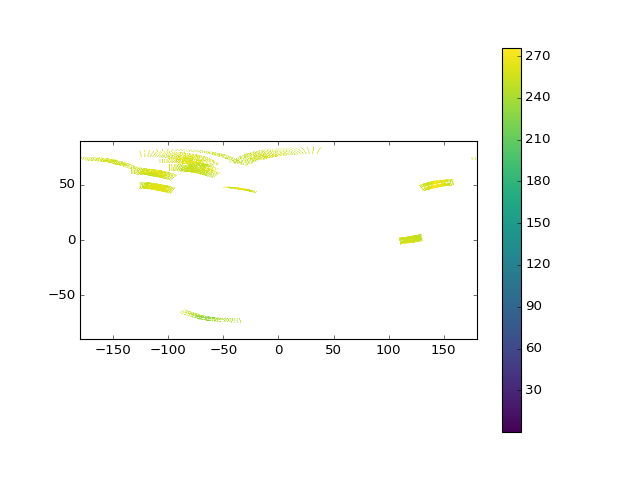

In [32]:
plot(df_small, 'longitude', 'latitude', reduction='mean', col_reduction='data')

Now let's retrieve and plot only satellite with ID = 3.

In [27]:
df_small_3 = df_small[df_small.satid == 3]  # Select only satellite ID 3.
print df_small_3.describe()  # What does our dataframe look like?

              data     latitude    longitude   satid         time
count  1380.000000  1380.000000  1380.000000  1380.0  1380.000000
mean    255.052261     6.632360    67.929581     3.0 -1418.456543
std      12.799337    57.901436   100.470734     0.0  1636.261108
min     223.730011   -74.900696   -90.351601     3.0 -2700.000000
25%     245.202496   -69.194147   -58.686126     3.0 -2661.000000
50%     256.664993    48.215199   136.878494     3.0 -2615.500000
75%     266.279999    50.803748   144.991219     3.0   745.000000
max     276.059998    54.877701   158.596603     3.0   791.000000


Let's plot only satellite ID 3.

<IPython.core.display.Javascript object>


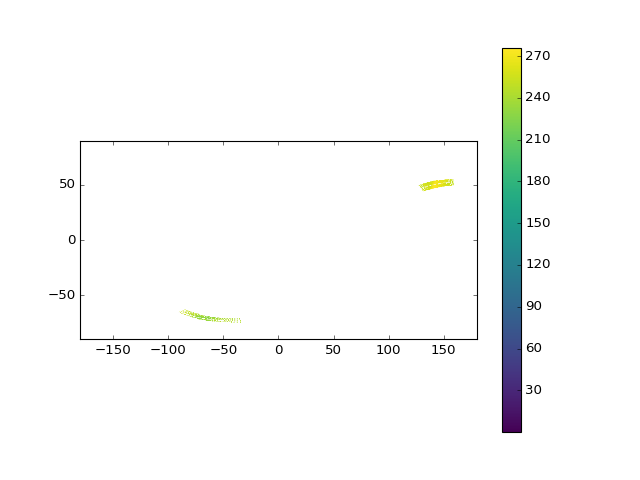

In [31]:
plot(df_small_3, 'longitude', 'latitude', reduction='mean', col_reduction='data')

## Large dataset

This larger dataset has a more respectable 1.22 million points in it. Again we will cut some of these back.

In [29]:
fp = '/data/users/dkillick/data/sa_avd'
fn = 'ATOVS_many_201605081200_v2.nc'
dataframe = cube_to_pandas_df(fp, fn, 'raw brightness temp')
df = dataframe[dataframe.data > 0]
# df = df[df.satid == 3]
print df.describe()

                data       latitude      longitude          satid  \
count  976570.000000  976570.000000  976570.000000  976570.000000   
mean      255.294937      10.625756      -1.290378     137.550004   
std        13.014584      51.743980      99.570564     102.657853   
min       155.919998     -89.869301    -179.999710       3.000000   
25%       251.010010     -35.735774     -83.955696       4.000000   
50%       255.250000      17.752850      -7.192300     209.000000   
75%       261.669983      59.131100      88.274075     223.000000   
max       286.080017      89.860298     179.999710     223.000000   

                time  
count  976570.000000  
mean      148.721237  
std      6197.959473  
min    -10799.000000  
25%     -5523.000000  
50%        46.000000  
75%      5390.000000  
max     10799.000000  


This time we want to plot using a reduction. We'll take the mean over the data at each aggregation within the plot.

<IPython.core.display.Javascript object>


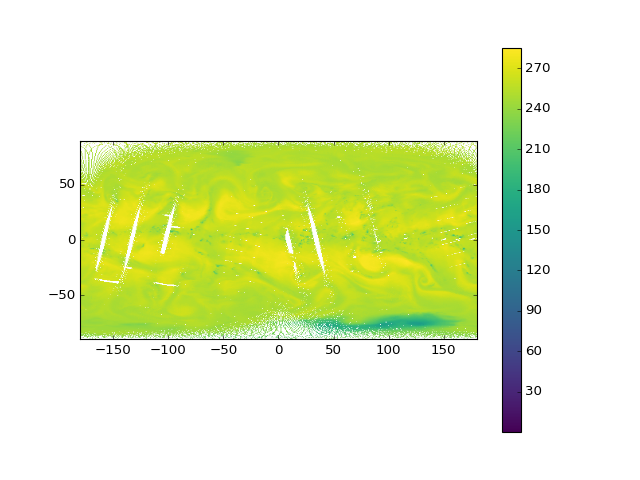

In [30]:
plot(df, 'longitude', 'latitude', reduction='mean', col_reduction='data')